In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

#### We load and split dataset intoa 90:5:5 ratio (train, validation, test)

In [3]:
base_path = "./data/IAM-Handwritten-Database/"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == '#': # we don't deal with commented lines
        continue
    if line.split(' ')[1] != "err": #we con't deal with pocharacterstentially badly segmented images
        words_list.append(line)

#we shuffle this data
np.random.shuffle(words_list)

#we split the dataset into a 90:5:5 ratio
split_index = int(0.9 * len(words_list))
train_samples = words_list[:split_index]
test_samples = words_list[split_index:]
validation_split_index = int(0.5 * len(test_samples))
validation_samples = test_samples[:validation_split_index]
test_samples = test_samples[validation_split_index:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples) # Assert that this is true before continuing


#### We load the image paths

In [21]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip() # Remove trailing spaces
        line_split = line_split.split(" ") # Split by spaces

        #Each line split has the corresponding format : part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        part1 = image_name.split('-')[0]
        part2 = image_name.split('-')[1]
        img_path = os.path.join(base_image_path, part1, part1 + '-' + part2, image_name + ".png")
        if os.path.getsize(img_path): # If file size > 0, we don't deal with empty files, there is some in the dataset
            paths.append(img_path)
            corrected_samples.append(file_line.split('\n')[0])
            print(file_line.split('\n')[0])
    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

e04-030-04-08 ok 170 1489 1499 120 39 JJ sure
k02-102-05-03 ok 182 836 1623 69 52 PP3A he
a01-082u-01-04 ok 172 1582 1043 234 88 IN during
m01-000-07-00 ok 196 339 1998 75 107 INO of
g01-031-07-06 ok 152 1912 2038 167 59 NN booty
f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy
n03-082-04-03 ok 165 992 1414 118 135 NN boy
g06-018c-04-05 ok 182 1298 1438 96 58 ATI The
g06-011j-06-06 ok 182 1222 1785 146 95 CC and
f04-024-01-06 ok 183 1104 981 60 70 IN in
g06-050k-00-07 ok 156 1842 717 85 76 PP$ his
m01-100-01-06 ok 185 1459 880 177 131 JJ flying
n02-033-04-01 ok 149 940 1486 353 85 VBD presented
p03-047-00-01 ok 191 393 739 127 80 UH No
g06-011e-08-00 ok 154 386 2190 70 44 CS as
p02-000-00-02 ok 182 752 727 97 85 AP few
c01-009-08-03 ok 182 1387 2363 170 81 NN work
c04-156-01-04 ok 175 989 912 65 142 INO of
h02-004-09-01 ok 191 776 2424 191 76 NNS items
g06-037o-03-02 ok 188 850 1274 214 75 VBD took
a02-000-00-06 ok 190 1658 722 22 20 *' "
l07-052-04-02 ok 155 645 1497 15 36 : :
c04-

#### We prepare the ground-truth labels

In [9]:
# We find the maximum length and the size of the vocabulary in the training dataset
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    # We split the line by spaces, take the last value (which is the actual word) and strip this
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char) # We add chars into the set, so idendic values won't be added
    max_len = max(max_len, len(label)) # max_len is equal to the max value between current max_len and len of current label
    train_labels_cleaned.append(label) # We add this label to the train_labels_cleaned list

characters = sorted(list(characters)) # We sort the set and convert it to a list
print(f"Max length = {max_len}")
print(f"Vocab = {characters}")
print(f"Vocab len = {len(characters)}")



Max length = 21
Vocab = ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab len = 78


#### We clean the validation and test label
We already cleaned the train dataset in the previous card

In [10]:
# Function that separates the actual word from the whole line and return the words list
def clean_labels(labels):
    clean_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        clean_labels.append(label)
    return clean_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

#### We build the character vocabulary

In [11]:
AUTOTUNE = tf.data.AUTOTUNE # Let tf decide the best tunning algos

# Mapping characters to integer -> returns a function
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters -> returns a function
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

#### Resizing images without distortion

In [12]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

#### Utilities variables and functions

In [13]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path) # Open file with tf
    image = tf.image.decode_png(image, channels=1) # transform to matrix of gray scale value
    image = distortion_free_resize(image, img_size) # Distort image
    image = tf.cast(image, tf.float32) / 255.0 # Transform image to data into matrix of gray scale float32 values in range [0, 1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    return tf.data.Dataset.from_tensor_slices(
        (image_paths, labels)
    ).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    ).batch(batch_size).cache().prefetch(AUTOTUNE)

#### Prepare Dataset objects

In [14]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

#### Define model

In [16]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

#### Evaluation metric
Edit Distance is the most widely used metric for evaluating OCR models. In this section, we will implement it and use it as a callback to monitor our model.

We first segregate the validation images and their labels for convenience.

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

#### Training the model

In [18]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 20.4241
1357/1357 [==============================] - 115s 79ms/step - loss: 13.6217 - val_loss: 11.8243
Epoch 2/10
1/1 [==============================] - 0s 15ms/step
Mean edit distance for epoch 2: 20.0729
1357/1357 [==============================] - 89s 66ms/step - loss: 10.6429 - val_loss: 9.4372
Epoch 3/10
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 3: 19.6693
1357/1357 [==============================] - 90s 67ms/step - loss: 8.7277 - val_loss: 7.4492
Epoch 4/10
1/1 [==============================] - 0s 21ms/step
Mean edit distance for epoch 4: 18.8072
1357/1357 [==============================] - 94s 70ms/step - loss: 7.0284 - val_loss: 5.5873
Epoch 5/10
1/1 [==============================] - 0s 24ms/step
Mean edit distance for epoch 5: 18.4088
1357/1357 [==============================] - 97s 71ms/step - loss: 5.7067 - val_loss: 4.6051
Epoch 6/10
1/1 [==

2/2 [==============================] - 0s 7ms/step


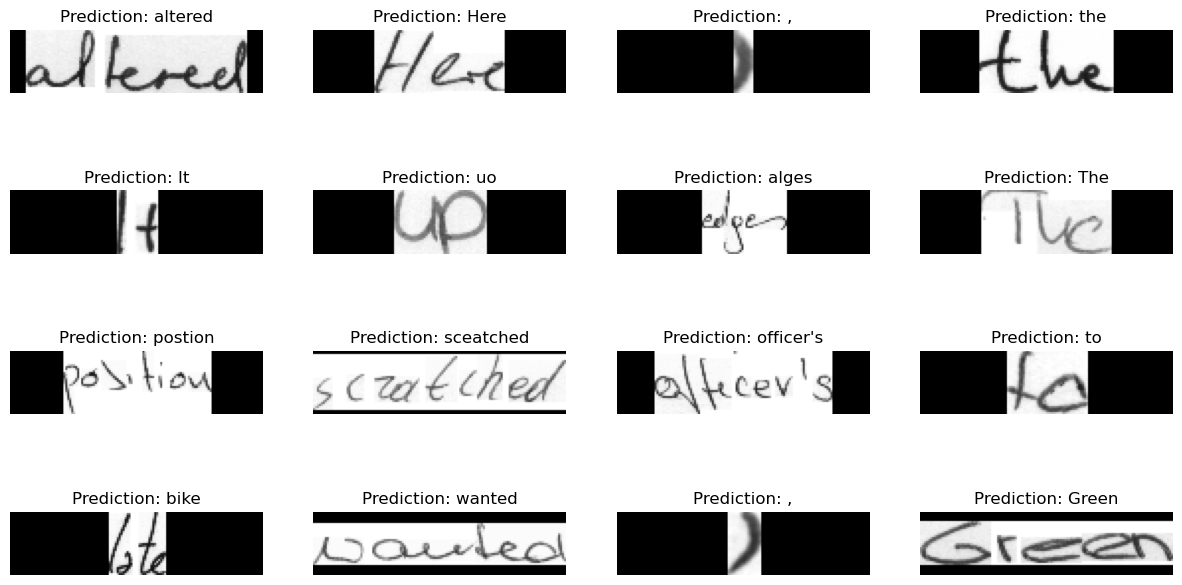

In [19]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()